## Lesson 3: 
### Exercise 1: A gaussian integral

In order to apply Monte Carlo integration we need to make sure that the function $p(x)$ is such that $\int{p(x)}dx = 1$. 

Since we know that $\int_{-\infty}^{+\infty} \mathscr{N}(x|0, \sigma)dx = 1$ and $\mathscr{N}$ is a symmetric function, it is also true that:
$$2 \int_{0}^{+\infty} \mathscr{N}(x|0, \sigma)dx = \int_{0}^{+\infty} \frac{2}{\sigma \sqrt{2 \pi}} \exp({-\frac{x^2}{2 \sigma^2}}) dx = 1$$

We can then rewrite the integral we want to compute as
$$I = \frac{\sigma \sqrt{2 \pi}}{2} \int_{0}^{+\infty} x^3 \frac{2}{\sigma \sqrt{2 \pi}} \exp({-\frac{x^2}{2 \sigma^2}}) dx$$
highlighting the function $p(x)$ inside the integral. Then by applying Monte Carlo integration formula:

$$I = \frac{\sigma \sqrt{2 \pi}}{2} \left[\frac{1}{N}\sum_{i=1}^{N} (x_i)^3\right]$$

Where $x_i$ are drawn from $p(x)$ simply by taking the modulus of samples drawn from the normal Gaussian distribution. This is automatically taking into account the factor of "2", since by taking the absolute values we're sampling each bin twice.

In [2]:
from scipy.stats import norm
import numpy as np
from pylab import plt
import math
from astropy.visualization import quantity_support
from tqdm.notebook import tqdm

sigma = 3
distG = norm(loc=0, scale=sigma)

#Theoretical integral (=2*sigma^4)
th_integral = 2*sigma**4

N = 10000
sample = np.abs(distG.rvs(N))
mc_integral = 0.5*sigma*((2*np.pi)**0.5)*np.mean(sample**3)

print(th_integral, mc_integral)

162 157.59496386897007


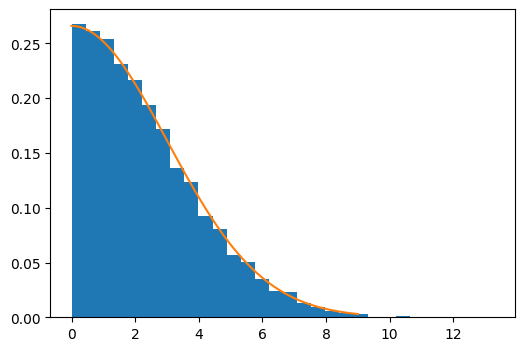

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.hist(sample, density=True, bins=30)
plt.plot(np.linspace(0,3*sigma,100), 2*distG.pdf(np.linspace(0, 3*sigma ,100)))

- Now let's repeat it for many values of $N$, checking for the consistency of the results ($I \rightarrow I_{th} = 2\sigma^4$ for $N \rightarrow +\infty$)

In [4]:
def integral_mc(N):
    sample = np.abs(distG.rvs(N))
    mc_integral = 0.5*sigma*((2*np.pi)**0.5)*np.mean(sample**3)
    relative_err = np.abs((th_integral-mc_integral)/th_integral)
    return mc_integral, relative_err

[]

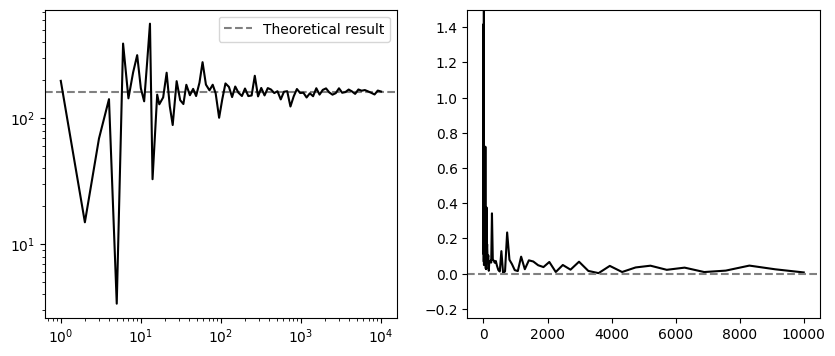

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,4));
plt.subplot(121)

N_values = np.unique(np.logspace(0, 4, 100, dtype=int))
plt.axhline(th_integral, c='gray', ls='--', label='Theoretical result')

results = np.array([integral_mc(n) for n in N_values])

integral_vals = np.array([pair[0] for pair in results])
error_vals = np.array([pair[1] for pair in results])

plt.plot(N_values, integral_vals, c='k')
plt.loglog()
plt.legend()

plt.subplot(122)
plt.plot(N_values, error_vals, c='k')
plt.axhline(0, c='gray', ls='--')
plt.ylim(-0.25,1.5)
plt.plot()

For increasing $N$, the result is converging towards the theoretical result, since the relative error between the two values approaches $0$.

---
Now let's do it many times for a fixed $N$ and check how the results are distributed.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

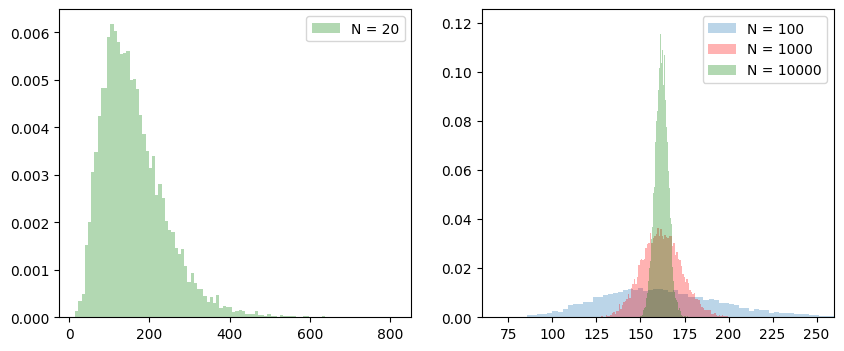

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# We fix the number of iterations
iterations = 10000
# Now we choose the number of samples for the MC integration
N_0 = 20 #Low N test
N_1 = 100
N_2 = 1000
N_3 = 10000
repeated_results_0 = np.array([integral_mc(N_0) for i in tqdm(range(0, iterations))])
repeated_results_1 = np.array([integral_mc(N_1) for i in tqdm(range(0, iterations))])
repeated_results_2 = np.array([integral_mc(N_2) for i in tqdm(range(0, iterations))])
repeated_results_3 = np.array([integral_mc(N_3) for i in tqdm(range(0, iterations))])

rep_integral_0 = np.array([pair[0] for pair in repeated_results_0])
rep_integral_1 = np.array([pair[0] for pair in repeated_results_1])
rep_integral_2 = np.array([pair[0] for pair in repeated_results_2])
rep_integral_3 = np.array([pair[0] for pair in repeated_results_3])

plt.subplot(121)
plt.hist(rep_integral_0, bins=100, density=True, color='g', alpha=0.3, label="N = {}".format(N_0));
plt.legend()
plt.subplot(122)
plt.hist(rep_integral_1, bins=100, density=True, alpha=0.3, label="N = {}".format(N_1));
plt.hist(rep_integral_2, bins=100, density=True, color='r', alpha=0.3, label="N = {}".format(N_2));
plt.hist(rep_integral_3, bins=100, density=True, color='g', alpha=0.3, label="N = {}".format(N_3));

plt.xlim(60, 260)
plt.legend()

If the value of $N$ is small ($N=20$), the distibution seems to have a heavier right end tail, while, when $N$ increases, the function is becoming more and more symmetric, and it resembles a Gaussian profile. 

Let's then fit the distribution obtained with the highest value on $N$ ($N=10000$) with a Gaussian, using a **parametric** model like *sklearn.GaussianMixture* with 1 component.

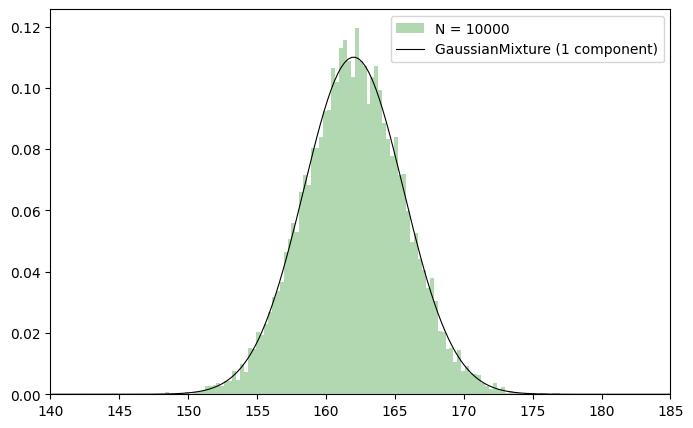

In [14]:
from sklearn.mixture import GaussianMixture

xgrid = np.linspace(50, 300, 1000)

gmm = GaussianMixture(n_components=1).fit(rep_integral_3.reshape(-1, 1))
logprob = gmm.score_samples(xgrid.reshape(-1, 1))

fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))

plt.hist(rep_integral_3, bins=100, density=True, color='g', alpha=0.3, label="N = {}".format(N_3));

plt.plot(xgrid, fx(np.array(xgrid)), c='k', label='GaussianMixture (1 component)', lw=0.8)
plt.xlim(140, 185)
plt.legend()

The fit looks quite accurate with 1 Gaussian component.

Let's "fit" it with a Gaussian centered around the *sample mean* and with a width equal to the *sample standard deviation*.

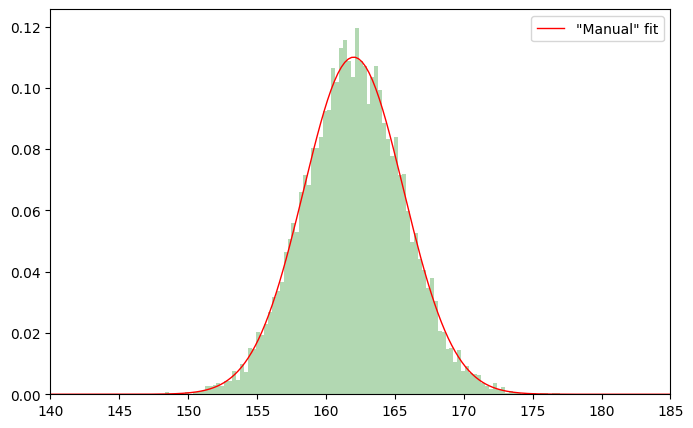

In [17]:
plt.hist(rep_integral_3, bins=100, density=True, alpha=0.3, color='g');
plt.xlim(140, 185)

Gauss = norm(loc=np.mean(rep_integral_3), scale=np.std(rep_integral_3))
plt.plot(xgrid, Gauss.pdf(xgrid), c='red', label='"Manual" fit', lw=1)
plt.legend()

For large $N$, the two fits are overlapping perfectly. The distribution of the integral results happens to be a Gaussian centered around the **sample mean** and with a width equal to the **sample standard deviation**.

The fact that the distribution is a Gaussian do make sense: the MC integration is performed by sampling a Gaussian profile and then computing a function of those samples, in analogy with the computation of a *sample mean*. A linear function of a Gaussian is still a Gaussian.

Now one could derive the error on $I$ analytically and check that it's compatible with the sample standard deviation of the Gaussian, for $N$ large enough.